<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/Generate_pte_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Stable diffusionのファインチューニングでPteの画像を作成したときの精度評価**

https://www.notion.so/Stable-diffusion-Lora-bc9427134dcd4596badd624720cc365d

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**尤度で評価**

CorneAIに画像入り(100枚)のフォルダを投入し、各クラスの尤度を計算する。今回は正常画像のトレーニングなので、正常と判定される尤度をピックアップし、平均+-標準偏差を算出する

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_dir = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte"
csv_files = glob.glob(f"{data_dir}/*")
print(csv_files)


['/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/2400.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/4800_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/1200_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/2400_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/1200.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/9600_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/9600.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/600.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/600_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/4800.csv', '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/sltphoto_pte/150_negative.csv', '/content/drive/MyDrive/研究/進行中の研究/角

In [4]:
import os
import pandas as pd

# Empty list to store dataframes
dfs = []

# Read each csv file, add 'step' and 'negative_prompt' columns based on file name, and append to the list
for file in csv_files:
    df = pd.read_csv(file, encoding='cp932')

    # Get the step number and negative prompt flag from the file name
    filename = os.path.splitext(os.path.basename(file))[0]

    if "negative" in filename:
        step = int(filename.split("_")[0])
        negative_prompt = True
    else:
        step = int(filename.split("_")[0])
        negative_prompt = False


    # Add 'step' and 'negative_prompt' columns
    df['step'] = step
    df['negative_prompt'] = negative_prompt

    dfs.append(df)

# Concatenate all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

# Calculate mean and standard deviation of '正常' score for each combination of 'step' and 'negative_prompt'
stats_df = df_combined.groupby(['step', 'negative_prompt'])['腫瘍性病変'].agg(['mean', 'std']).reset_index()

stats_df


,step,negative_prompt,mean,std
0,150,False,0.264530,0.295098
1,150,True,0.203198,0.267325
2,300,False,0.126953,0.246074
3,300,True,0.226843,0.284731
4,600,False,0.282529,0.350459
5,600,True,0.282529,0.350459
6,1200,False,0.651541,0.375142
7,1200,True,0.596824,0.378765
8,2400,False,0.769705,0.274248
9,2400,True,0.786984,0.290143


In [ ]:
df_combined

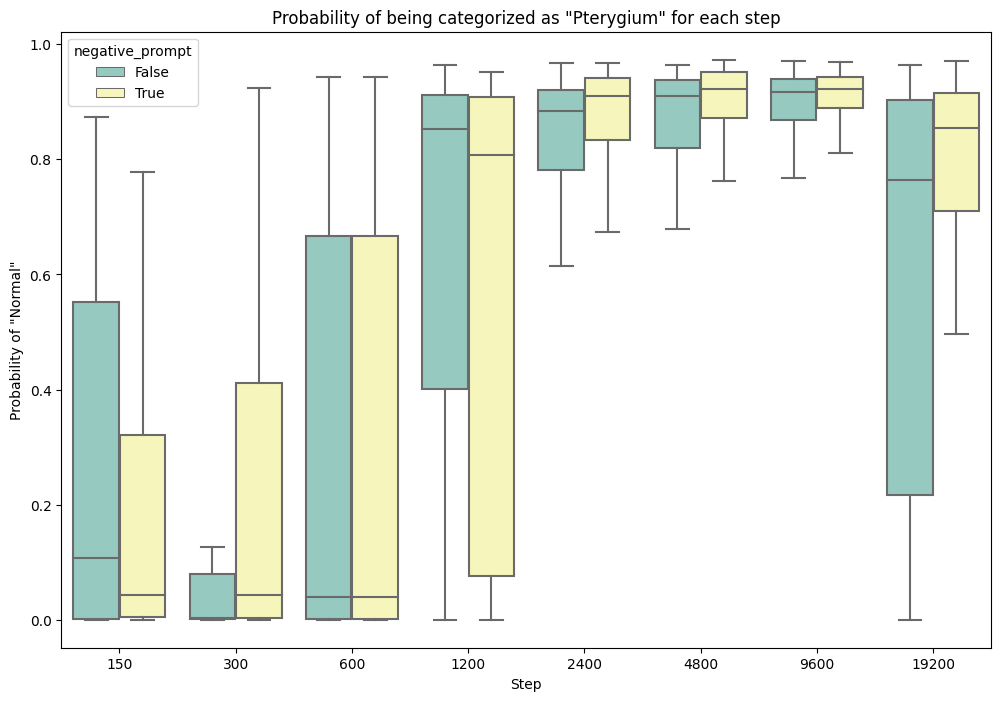

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x='step', y='腫瘍性病変', hue='negative_prompt', data=df_combined, palette="Set3", showfliers = False)
plt.title('Probability of being categorized as "Pterygium" for each step')
plt.xlabel('Step')
plt.ylabel('Probability of "Normal"')
plt.show()

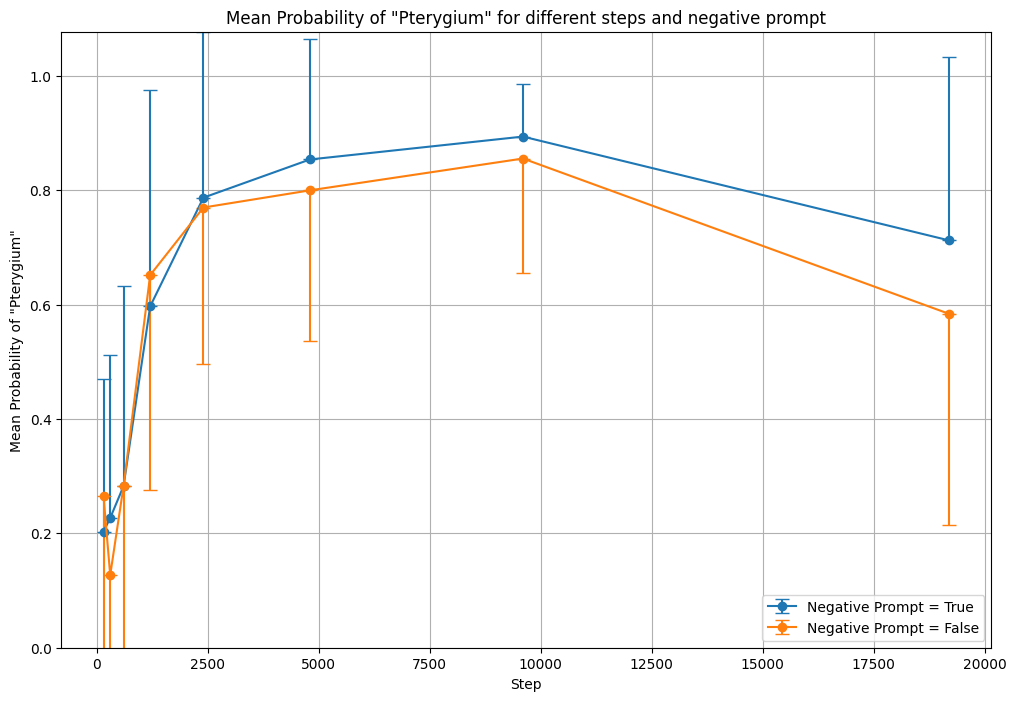

In [9]:
import matplotlib.pyplot as plt

# Separate dataframes for negative_prompt == True and False
df_true = stats_df[stats_df['negative_prompt'] == True]
df_false = stats_df[stats_df['negative_prompt'] == False]

# Set y limit
ylim_max = max((df_true['mean'] + df_true['std']).max(), (df_false['mean'] + df_false['std']).max())

# Plotting with corrected error bars
plt.figure(figsize=(12, 8))

plt.errorbar(df_true['step'], df_true['mean'], yerr=[[0]*len(df_true['std']), df_true['std']],
             fmt='-o', capsize=5, label='Negative Prompt = True')
plt.errorbar(df_false['step'], df_false['mean'], yerr=[df_false['std'], [0]*len(df_false['std'])],
             fmt='-o', capsize=5, label='Negative Prompt = False')

plt.xlabel('Step')
plt.ylabel('Mean Probability of "Pterygium"')
plt.ylim(0, ylim_max)
plt.legend()
plt.grid(True)
plt.title('Mean Probability of "Pterygium" for different steps and negative prompt')
plt.savefig('mean_probability_plot.png')
plt.show()



###**各ステップ数における尤度の比較**


In [ ]:
from scipy.stats import shapiro

df_filtered = df_combined[df_combined['negative_prompt'] == False].sort_values(by='step')


# Check if the data follow a normal distribution for each step
normality_test_results = {step: shapiro(df_filtered[df_filtered['step'] == step]['正常']).pvalue
                          for step in df_filtered['step'].unique()}
normality_test_results

# →データが正規分布でないためKruskak-Wallis検定を行う

{150: 1.6087844780831785e-19,
 300: 1.9584514298443308e-18,
 600: 7.873653985746021e-12,
 1200: 1.3870738905506525e-16,
 2400: 1.6756784449733711e-19,
 4800: 8.295994049864064e-20,
 9600: 1.0886805557868478e-21,
 19200: 1.4164375853068088e-20}

In [ ]:
from scipy.stats import kruskal

# Prepare data for each step
data_for_test = [df_filtered[df_filtered['step'] == step]['正常'] for step in df_filtered['step'].unique()]

# Perform the Kruskal-Wallis H test
h, p = kruskal(*data_for_test)

h, p

# → Kruskal-Wallis検定では有意差あり

(99.48837500023915, 1.3758832604442938e-18)

In [ ]:
from scipy.stats import mannwhitneyu
from itertools import combinations

"""
#　事後検定(各群間の有意差を、Mann-Whitney-Uを用いて算出)
"""

# Get the unique steps
steps = df_filtered['step'].unique()

# Calculate the number of pairs for Bonferroni correction
num_pairs = len(list(combinations(steps, 2)))

# Perform Mann-Whitney U tests for each pair of steps
p_values = {}
for step1, step2 in combinations(steps, 2):
    data1 = df_filtered[df_filtered['step'] == step1]['正常']
    data2 = df_filtered[df_filtered['step'] == step2]['正常']
    _, p = mannwhitneyu(data1, data2, alternative='two-sided')
    p_values[(step1, step2)] = p / num_pairs  # Apply Bonferroni correction


# Convert the p-values into a dataframe
p_values_df = pd.DataFrame(index=steps, columns=steps)

# Fill the dataframe with the p-values
for (step1, step2), p in p_values.items():
    p_values_df.loc[step1, step2] = p
    p_values_df.loc[step2, step1] = p

p_values_df.fillna(1, inplace=True)  # Fill the diagonal with 1s

p_values_df



,150,300,600,1200,2400,4800,9600,19200
150,1.000000e+00,8.421134e-03,2.992410e-11,0.000728,2.329946e-02,2.984193e-02,3.650262e-03,1.422637e-02
300,8.421134e-03,1.000000e+00,9.954086e-09,0.007238,4.344293e-03,1.266979e-02,2.572086e-04,1.706268e-03
600,2.992410e-11,9.954086e-09,1.000000e+00,0.000013,2.848834e-11,3.238024e-10,8.506173e-14,2.646359e-12
1200,7.281338e-04,7.237864e-03,1.317739e-05,1.000000,2.932970e-04,1.551178e-03,1.214737e-05,1.085134e-04
2400,2.329946e-02,4.344293e-03,2.848834e-11,0.000293,1.000000e+00,1.713287e-02,1.058344e-02,2.687402e-02
4800,2.984193e-02,1.266979e-02,3.238024e-10,0.001551,1.713287e-02,1.000000e+00,2.647403e-03,1.033828e-02
9600,3.650262e-03,2.572086e-04,8.506173e-14,0.000012,1.058344e-02,2.647403e-03,1.000000e+00,1.646266e-02
19200,1.422637e-02,1.706268e-03,2.646359e-12,0.000109,2.687402e-02,1.033828e-02,1.646266e-02,1.000000e+00


###**Negative promptの有無による比較**

Negative promptの有無による尤度を対応のないt検定で比較する

In [ ]:
# Perform a Mann-Whitney U test for each step, comparing '正常' between negative_prompt True and False
p_values_prompt = {}

for step in df_combined['step'].unique():
    data_true = df_combined[(df_combined['step'] == step) & (df_combined['negative_prompt'] == True)]['正常']
    data_false = df_combined[(df_combined['step'] == step) & (df_combined['negative_prompt'] == False)]['正常']
    _, p = mannwhitneyu(data_true, data_false, alternative='two-sided')
    p_values_prompt[step] = p

p_values_prompt

{2400: 0.2341063026858261,
 4800: 0.2913488142150811,
 1200: 0.18015058741241596,
 9600: 0.12282711300810296,
 600: 1.0,
 150: 0.056083681009466625,
 300: 0.6346702087997885,
 19200: 0.5466488635061282}

In [ ]:
### 対応のないt検定だとこちら

from scipy.stats import ttest_ind

# Load the csv files into a dictionary of dataframes
dataframes = {}
for csv_file in csv_files:
    dataframes[csv_file] = pd.read_csv(csv_file, encoding='cp932')
    print(csv_file)

# Prepare a dictionary to store the results
t_test_results = {}

# Loop over each unique step number
#step_numbers = [150, 300, 600, 1200, 2400, 4800, 9600]
step_numbers = set([int(os.path.splitext(os.path.basename(name))[0]) for name in csv_files if os.path.splitext(os.path.basename(name))[0].isdigit()])
step_numbers = sorted(step_numbers)

for step in step_numbers:
    # Find corresponding dataframe names
    df_name1 = f'{os.path.dirname(csv_file)}/{step}.csv'
    df_name2 = f'{os.path.dirname(csv_file)}/{step}_negative.csv'

    # If both dataframes exist, perform the t-test
    if df_name1 in dataframes and df_name2 in dataframes:
        df1 = dataframes[df_name1]
        df2 = dataframes[df_name2]

        # Perform the t-test on the "正常" column
        t_stat, p_val = ttest_ind(df1["正常"], df2["正常"])
        t_test_results[step] = (t_stat, p_val)

t_test_results #


#**FID scoreを用いた画質の評価**

FID for Pytorch
https://github.com/mseitzer/pytorch-fid

FID scoreとは？？
https://data-analytics.fun/2021/12/31/understanding-fid/

In [ ]:
!pip install pytorch_fid


In [ ]:
!unzip "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/generated_normal.zip" -d "/content/generated_normal"

In [ ]:
# Resize images to 299x299 pixcels
from PIL import Image
from tqdm import tqdm
import os

def resize_images(folder_path, size=(299, 299)):
    files_to_resize = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png") or file.endswith(".jpg"):
                files_to_resize.append(os.path.join(root, file))

    for file_path in tqdm(files_to_resize, desc=f'Resizing images in {folder_path}'):
        img = Image.open(file_path)
        img_resized = img.resize(size)
        img_resized.save(file_path)

# Resize images in the 'true' folder
true_folder = '/content/generated_normal/true'
resize_images(true_folder)

# Resize images in other folders
parent_folder = '/content/generated_normal'
folders = os.listdir(parent_folder)
for folder in folders:
    if folder == 'true':
        continue
    other_folder = os.path.join(parent_folder, folder)
    resize_images(other_folder)

In [ ]:
import os
import pandas as pd

# Path to the folder with the real images
true_images_folder = '/content/generated_normal/true'

# Path to the parent folder of the generated images
parent_folder = '/content/generated_normal'

# Get a list of all folders in the parent folder
folders = os.listdir(parent_folder)

# Create an empty dataframe to store FID scores
fid_scores = pd.DataFrame(columns=['folder', 'fid_score'])

for folder in folders:
    if folder == 'true':
        continue
    other_folder = os.path.join(parent_folder, folder)

    # Calculate the FID score
    fid_score = !python -m pytorch_fid {true_folder} {other_folder}  # Note: replace this with your FID calculation command
    print(fid_score)
    fid_score = float(fid_score[11].split(':')[1].strip())  # Note: adjust this line based on the output of your FID calculation command
    fid_score = round(fid_score, 2) #round FID value to two decimal places

    # Add the FID score to the dataframe
    print(f"{folder}: {fid_score}")
    current_score = pd.DataFrame({'folder': [folder], 'fid_score': [fid_score]})
    fid_scores = pd.concat([fid_scores, current_score], ignore_index=True)

# Print the dataframe
print(fid_scores)

In [ ]:
# Extract the step number and whether the row is negative into new columns
fid_scores['step'] = fid_scores['folder'].str.extract('(\d+)').astype(int)
fid_scores['negative'] = fid_scores['folder'].str.contains('negative')

# Sort by the new columns
fid_scores_sorted = fid_scores.sort_values(['step', 'negative'])

# Reset the index of the sorted DataFrame
fid_scores_sorted = fid_scores_sorted.reset_index(drop=True)

# Print the sorted DataFrame
fid_scores_sorted


In [ ]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig, ax = plt.subplots()

# For each value of 'negative'
for negative in [True, False]:
    # Select the rows where 'negative' is the current value
    subset = fid_scores_sorted[fid_scores_sorted['negative'] == negative]
    # Plot 'step' vs 'fid_score' for the selected rows
    ax.plot(subset['step'], subset['fid_score'], label=f'negative={negative}')

# Add title and labels
ax.set_title('FID Score by Step Number')
ax.set_xlabel('Step Number')
ax.set_ylabel('FID Score')

# Add a legend
ax.legend()

# Display the plot
plt.show()


#**人力評価用データセットの作成**

In [ ]:
!unzip "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/画像生成/generated_normal.zip" -d "/content/generated_normal"